# Relative Entropy with `limlam_mocker`

Author: Patrick Horlaville

- This notebook is intended to present how to produce a point-wise relative entropy (PRE) analysis over intensity maps generated through `limlam_mocker`. 

- I suggest getting acquainted with the `limlam_mocker` general use readme first.

- $\textbf{It's important to note}$ that I meant to write this document with the express intent of infusing some intuitive sense of what is the PRE and why we are using it, rather than doing a comprehensive derivation and formal breakdown. This is why some parts may feel a bit 'hand wavy'. For more details, I invite you to consult section 2.2 and 4.3 of my paper for more rigorous details on it (https://arxiv.org/abs/2309.15733).

- For supplemental information or any question you might have going through this readme, refer to the paper, or contact me at : phorlaville24@ubishops.ca

First, read this notebook from the root limCode folder, so the imports work correctly. Therefore, this whole notebook will run as though its location is:

In [1]:
%cd '/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2/'

/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2


Then, import all packages:

In [2]:
# base imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# various math package imports
import math
from scipy import special
from scipy import interpolate
import astropy.units as u 
from scipy.ndimage import gaussian_filter

# base intensity mapping package
from lim import lim 

# My plotting preferences
matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) 
#plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Dongwoo's plotting preferences, which I used for my paper:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{tgheros}\\usepackage{sansmath}\\sansmath'

# used to check on the running time of particular computations
from datetime import datetime

Then, we can load the lim model, here for [C II]:

In [3]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


We set our simulation parameters:

In [4]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            dnu = 2.8*u.GHz,
            nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
            tobs = 40000*u.h,
            Omega_field = 4*u.deg**2,
            catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

And load the cube of intensities:

In [5]:
cii_cube_zdex04 = m_cii.maps

Loading .npz catalogues...


For the relative entropy analysis, we are interested in the distribution of the voxels' [C II] signal distribution from our cube:

In [6]:
binning = np.logspace(0, np.log10(50000), 100)
center = (binning[:-1] + binning[1:]) / 2

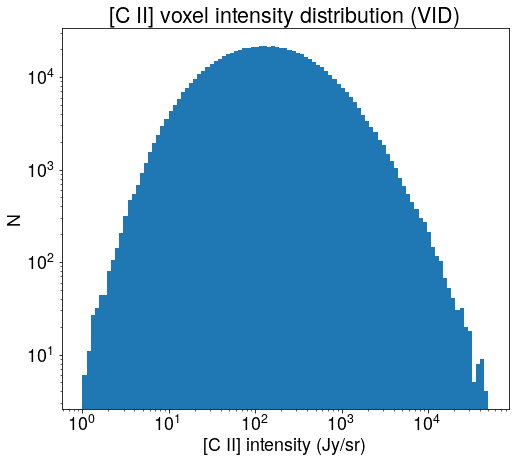

In [13]:
n_cii_zdex04, _, _ = plt.hist(cii_cube_zdex04.value.flatten(), bins = binning)

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.title('[C II] voxel intensity distribution (VID)')

plt.xscale('log')

Notice in the update function, we have set the 'zdex' parameter to 0.4. Let's say that we are interested in analyzing how does the distribution of [C II] intensities change as this parameter changes (it's the whole idea of the relative entropy analysis): we can just update the parameters of our simulation, and save the corresponding data cubes. The amount by which to change that fiducial parameter is an arbitrary choice, all depending on the value of the fiducial parameter itself and the kind of change you want to analyze. In doubt, try some initial amount and see how it changes the distribution: if it doesn't change anything, try cranking it up, and if it changes too drastically, try lowering it. 

Here, we are looking at a deviation of zdex = 0.4 $\pm$ 0.1, so we change 'zdex' to 0.3 and 0.5:

In [8]:
m_cii.update(model_par = {'zdex': 0.3,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [9]:
cii_cube_zdex03 = m_cii.maps

Loading .npz catalogues...


In [10]:
m_cii.update(model_par = {'zdex': 0.5,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [11]:
cii_cube_zdex05 = m_cii.maps

Loading .npz catalogues...


To start with, we can simply plot the histogram of the distribution of [C II] intensities for the three versions of 'zdex'. As you increase/decrease the parameter, what happens to that distribution? Did you expect that? Why? How does that parameter impact the 'response function', as Dick would say? How does it tie back to the underlying physics prescribed by that parameter? These are relevant questions you can think of all throughout the relative entropy analysis.

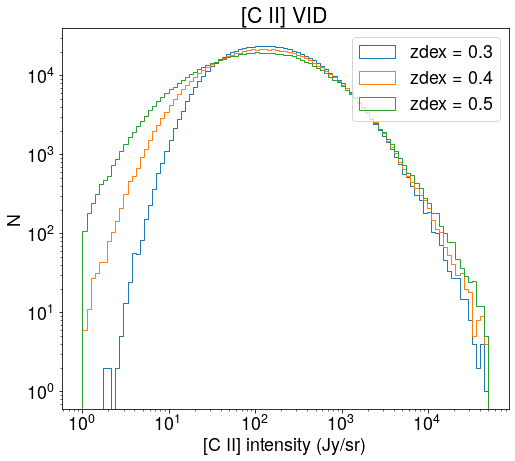

In [12]:
n_cii_zdex03, _, _ = plt.hist(cii_cube_zdex03.value.flatten(), bins=binning, label='zdex = 0.3', histtype='step')
n_cii_zdex04, _, _ = plt.hist(cii_cube_zdex04.value.flatten(), bins=binning, label='zdex = 0.4', histtype='step')
n_cii_zdex05, _, _ = plt.hist(cii_cube_zdex05.value.flatten(), bins=binning, label='zdex = 0.5', histtype='step')


plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.xscale('log')
plt.title('[C II] VID')
plt.legend()

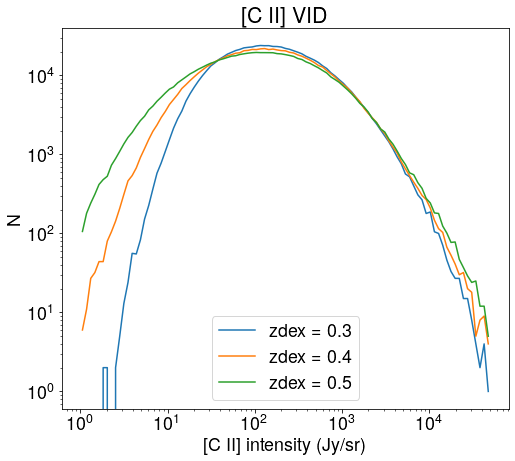

In [14]:
plt.plot(center, n_cii_zdex03, label = 'zdex = 0.3')
plt.plot(center, n_cii_zdex04, label = 'zdex = 0.4')
plt.plot(center, n_cii_zdex05, label = 'zdex = 0.5')

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.xscale('log')
plt.title('[C II] VID')
plt.legend()

Here, it's interesting to note that as the 'zdex' parameter increases, the position of the peak of the distribution remains largely unchanged, but its spread increases. Does it make sense? The 'zdex' parameter controls the scatter in metallicity: the greater its value, the greater the scatter will be added to the metallicity, and consequentially the greater the scatter will be added to the [C II] luminosity. Therefore, we would expect a higher 'zdex' to result in a "flatter" distribution of the [C II] intensities, where each luminosity is bumped up or down by a greater factor. This is totally in line with what the plot above shows, with the spread of the distribution increasing with 'zdex'. 

We can additionally comment on the physical significance of the parameter: in our work, the 'zdex' parameter adds scatter to the metallicity, which really is a proxy for scatter in [C II] luminosity. This parameter is meant to account for the stochastic processes induced by, e.g., baryonic physics and small scale random processes which are too complicated to model for our work here. Therefore, instead of carrying out painstaking time to figure out and implement those details, we simply add a 'randomness' factor to our [C II] luminosity function, that we draw from a log-normal distribution. If we increase the magnitude of this randomness, all intensities are scaled up or down by a greater factor on average, pushing the signal from its mean value towards more extreme values, both high and low. 

Here's the informal but intuitive way I like to think about going forward: all this qualitative description was made by comparing the 3 individual PDFs shown above, but how can we reduce that data for it to be more clear and consise?

First, we can look at how each alternate case (the 'zdex' = 0.3 and 'zdex' = 0.5 PDFs) deviate from the fiducial one (the 'zdex' = 0.4 PDF). Here, I plot the log ratio of each alternate PDF to the fiducial PDF:

/tmp/ipykernel_179016/3975994419.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(center, np.log(n_cii_zdex03/n_cii_zdex04), label = 'zdex=0.3/zdex=0.4')


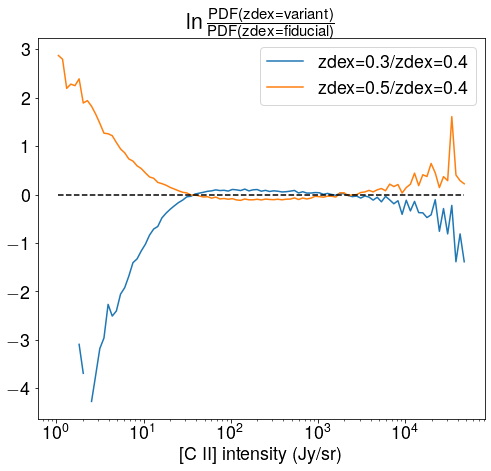

In [24]:
plt.plot(center, np.log(n_cii_zdex03/n_cii_zdex04), label = 'zdex=0.3/zdex=0.4')
plt.plot(center, np.log(n_cii_zdex05/n_cii_zdex04), label = 'zdex=0.5/zdex=0.4')

plt.xlabel('[C II] intensity (Jy/sr)')
plt.title(r'$\ln{\frac{\rm{PDF(zdex=variant)}}{\rm{PDF(zdex=fiducial)}}}$')

plt.xscale('log')
plt.legend()

plt.hlines(y = 0, xmin = center[0], xmax = center[-1], linestyle = '--', color = 'k')

What does this plot tell us? Let's look at the orange line, for example, which is the transition when 'zdex' goes from 0.4 to 0.5. When it's above zero, the PDF of the [C II] intensities moves up, and conversely when it's below zero. Therefore, when the 'zdex' factor moves from 0.4 to 0.5, the PDF of the [C II] intensities moves up at its edges and moves down near its center: there will be more [C II] intensities of lower and higher values, and less [C II] intensities of median value. The converse observation can be made with 0.3 to 0.4 'zdex' transition.

These observations are equivalent to what was said earlier with the three PDFs, the difference here is that we 'flattened' the fiducial distribution on the y=0 axis, so-to-speak: for example, if the orange line on this plot was a flat y=0 line, this would mean that changing the 'zdex' factor from 0.4 to 0.5 has not changed the distribution of [C II] intensities.

In the same intuitive and informal spirit as before, how can we further reduce the data to make those observations more directly?

Let's go back to our orange and blue line. For now, ignore the intensity axis (imagine we're interested in one intensity in particular, for example), and all we care about is the alternate parameter (in our case, the alternate 'zdex' value, that we can call x) and the value of the line (the log ratio of that alternate 'zdex' value PDF to the fiducial one, that we can call y). This means that for each alternate line, we have one data point (x, y), which gives us two points (x$_0$, y$_0$) and (x$_1$, y$_1$), where x$_0$=0.3 and x$_1$=0.5 are the alternate 'zdex' values: by increasing x$_0$ (by increasing the 'zdex' parameter value), the log ratio of the alternate PDF to the fiducial PDF has changed. One easy way to quantify that change is simply to compute the rate of that change: (y$_1$-y$_0$)/(x$_1$-y$_0$), which will then give you one number that tells you by how much will the PDF change as you increase the parameter.

Going back to our orange and blue lines, this suggests subtracting the blue line from the orange one, and dividing the result by the change in parameter:

/tmp/ipykernel_179016/3924886235.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(center, (np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04))/dzdex)


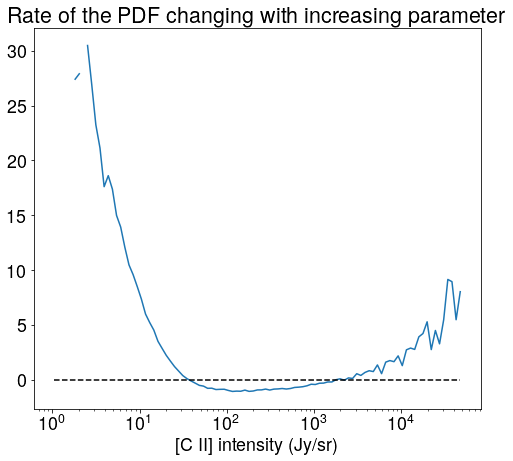

In [25]:
dzdex=0.2 # the parameter change from zdex=0.3 to zdex=0.5
plt.plot(center, (np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04))/dzdex)

plt.xlabel('[C II] intensity (Jy/sr)')
#Àplt.ylabel('N')
#plt.yscale('log')
plt.xscale('log')
plt.title('Rate of the PDF changing with increasing parameter')

plt.hlines(y = 0, xmin = center[0], xmax = center[-1], linestyle = '--', color = 'k')

Because the change from 0.3 to 0.4 and from 0.4 to 0.5 in 'zdex' is in good part the same (which makes sense, and we can tell from the previous plot, where the blue and orange are opposite to each other), the average variation with increasing parameter looks much like the one from 0.4 to 0.5 dex (the orange line from the previous plot).

Furthermore, we can use this rate as a weight for our fiducial [C II] intensity distribution (voxel intensity distribution $-$ VID)

/tmp/ipykernel_179016/1500885957.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(center, n_cii_zdex04*(np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04))/dzdex)


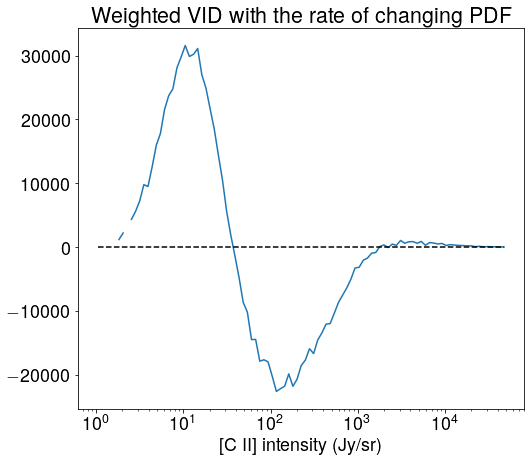

In [28]:
plt.plot(center, n_cii_zdex04*(np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04))/dzdex)

plt.xlabel('[C II] intensity (Jy/sr)')
#Àplt.ylabel('N')
#plt.yscale('log')
plt.xscale('log')
plt.title('Weighted VID with the rate of changing PDF')

plt.hlines(y = 0, xmin = center[0], xmax = center[-1], linestyle = '--', color = 'k')

Now, what does this plot tell us? It tells us that the amount of [C II] intensities in our cube covering the regions on this plot where the line is above 0 will increase as the value of the parameter increases, and conversely if the line is below 0. A flat line at 0 means that bumping the parameter up or down does not affect the distribution of the [C II] intensities within our cube.  

This means that in our example here, as the 'zdex' parameter increases: 

- 1) there will be more [C II] intensities at lower levels (between ~1 and ~30 Jy/sr)

- 2) there will be less [C II] intensities near the center (between ~30 and ~1000 Jy/sr)

- 3) and there will be an increase of [C II] intensities at higher intensities (above ~1000 Jy/sr, albeit that increase won't be nearly as much compared to the one at lower intensities).


In other words, this plot tells us how does varying the parameter (in this case, 'zdex') will impact the PDF of the [C II] intensities. This is the differential PRE! If you integrate this plot across the intensity axis, you obtain a measure which quantifies the distance between the fiducial and variant PDF. In my work, I did not perform that integration because there is plenty of information in the differential PRE encoded from the underlying physics that yielded the difference between the fiducial and variant PDF: in essence, you can look at how that distance changes as a function of intensity, and that is rather interesting!

- *$\textit{Note}$* that I mentioned that the region above 0 indicates an increase in the [C II] intensities PDF with increasing the parameter *only* because I subtracted the lower variant line to the higher one ('zdex=0.5' line - 'zdex=0.3' line), rather than the inverse (in which case the region above 0 would indicate an increase in the PDF with *decreasing* parameter). I then divided it by the range in that parameter's range (0.5 - 0.3) such that the resulting quantity is a 'rate' which does not depend on the specific range I chose for my variant parameter. This is why this quantity is labelled $\Delta$PRE/$\Delta \lambda$ in my paper, with $\lambda$ representing the chosen parameter.

In summary, this tool allows to inspect how will the variation of my parameters impact the PDF of the signal I'm targetting. Here, I only showed the variation of one of my simulation parameters, but the same can be done for any other variable that parametrizes the signal.

# Other working case: cosmological non-gaussianities

Lightcones are in the redshift range [3.44, 4.10] so mean redshift is 3.77; therefore nuObs is set to be $\frac{1897 \rm{GHz}}{1+3.77} \sim 400 \rm{GHz}$, 1897 GHz being the restframe frequency of [C II]

The smallest frequency is attained at the highest redshift, which would be $\frac{1897 \rm{GHz}}{1+4.10} \sim 372 \rm{GHz}$. The highest frequency is attained at the smallest redshift, which would be $\frac{1897 \rm{GHz}}{1+3.44} \sim 427 \rm{GHz}$. Therefore, the frequency range is [372, 427] GHz, covering 427 GHz - 372 GHz = 55 GHz. Therefore, Delta_nu is set to 55 GHz.

The lightcone is at an average redshift of 3.77, which corresponds to an average comoving radial distance of 7150 MPc, or 7.15Gpc (To calculate this, I simply used Ned Wright's handy cosmo calculator: astro.ucla.edu/~wright/CosmoCalc.html). The lightcone box is 500 Mpc by 500 Mpc in the RA/Dec directions (which makes it a 500 Mpc x 500 Mpc x 7150 Mpc in comoving space), so the comvoving perpendicular size of the box is 500 Mpc. I approximate the angular size of the box $\theta$ to be $tan(\theta) = x/d$, where $x$ is the comoving perpendicular size of the box and $d$ is the comoving radial distance of the box. In this case, we hence have $tan(\theta) = 0.5\rm{Gpc}/7.15\rm{Gpc}$, such that $\theta \sim$ 0.07 rad $\sim$ 4 deg. Therefore, the lightcone surface is 4 deg x 4 deg in the observing direction, so we set Omega_field to be 16 deg². These are first-order approximations, which can be refined if necessary!

In [38]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            dnu = 2.8*u.GHz,
            nuObs = 400*u.GHz,
            Delta_nu = 55*u.GHz,
            tobs = 40000*u.h,
            Omega_field = 16*u.deg**2,
            catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [35]:
lc_paths_g = '/mnt/scratch-lustre/horlaville/nate_sims/june_9_2023/gaussian/'
from os import listdir
from os.path import isfile, join
gaussian_lightcones = [f for f in listdir(lc_paths_g) if isfile(join(lc_paths_g, f))]
gaussian_lightcones.remove('pksc3npz.py')
for i in range(len(gaussian_lightcones)):
    gaussian_lightcones[i] = lc_paths_g+gaussian_lightcones[i]

In [37]:
lc_paths = '/mnt/scratch-lustre/horlaville/nate_sims/june_9_2023/ngaussian/'
from os import listdir
from os.path import isfile, join
NonG_lightcones = [f for f in listdir(lc_paths) if isfile(join(lc_paths, f))]
NonG_lightcones.remove('pksc3npz.py')
for i in range(len(NonG_lightcones)):
    NonG_lightcones[i] = lc_paths+NonG_lightcones[i]

In [39]:
gaussian_cubes = [0 for i in range(len(gaussian_lightcones))]

print('Loading '+str(len(gaussian_lightcones))+' lightcones')
print('----------------------------------')

for i in range(len(gaussian_lightcones)):
    
    m_cii.update(catalogue_file = gaussian_lightcones[i])
    
    print('Loading '+str(i)+'th lightcone...')
    gaussian_cubes[i] = m_cii.maps
    print('Done with '+(str(i))+'th lightcone!')
    print('----------------------------------')

Loading 16 lightcones
----------------------------------
Loading 0th lightcone...
Loading .npz catalogues...
Done with 0th lightcone!
----------------------------------
Loading 1th lightcone...
Loading .npz catalogues...
Done with 1th lightcone!
----------------------------------
Loading 2th lightcone...
Loading .npz catalogues...
Done with 2th lightcone!
----------------------------------
Loading 3th lightcone...
Loading .npz catalogues...
Done with 3th lightcone!
----------------------------------
Loading 4th lightcone...
Loading .npz catalogues...
Done with 4th lightcone!
----------------------------------
Loading 5th lightcone...
Loading .npz catalogues...
Done with 5th lightcone!
----------------------------------
Loading 6th lightcone...
Loading .npz catalogues...
Done with 6th lightcone!
----------------------------------
Loading 7th lightcone...
Loading .npz catalogues...
Done with 7th lightcone!
----------------------------------
Loading 8th lightcone...
Loading .npz catalogue

In [40]:
NonG_cubes = [0 for i in range(len(NonG_lightcones))]

print('Loading '+str(len(NonG_lightcones))+' lightcones')
print('----------------------------------')

for i in range(len(NonG_lightcones)):
    
    m_cii.update(catalogue_file = NonG_lightcones[i])
    
    print('Loading lightcone #'+str(i+1)+'...')
    NonG_cubes[i] = m_cii.maps
    print('Done with lightcone #'+(str(i+1))+'!')
    print('----------------------------------')

Loading 32 lightcones
----------------------------------
Loading lightcone #1...
Loading .npz catalogues...
Done with lightcone #1!
----------------------------------
Loading lightcone #2...
Loading .npz catalogues...
Done with lightcone #2!
----------------------------------
Loading lightcone #3...
Loading .npz catalogues...
Done with lightcone #3!
----------------------------------
Loading lightcone #4...
Loading .npz catalogues...
Done with lightcone #4!
----------------------------------
Loading lightcone #5...
Loading .npz catalogues...
Done with lightcone #5!
----------------------------------
Loading lightcone #6...
Loading .npz catalogues...
Done with lightcone #6!
----------------------------------
Loading lightcone #7...
Loading .npz catalogues...
Done with lightcone #7!
----------------------------------
Loading lightcone #8...
Loading .npz catalogues...
Done with lightcone #8!
----------------------------------
Loading lightcone #9...
Loading .npz catalogues...
Done with li

In [86]:
# There are twice as many NonG lightcones as gaussian ones; for adequate comparison, pick half
NonG_cubes_cut = NonG_cubes[0:32]

In [107]:
binning = np.logspace(np.log10(5e0), np.log10(4e6), 100)
center = (binning[:-1] + binning[1:]) / 2

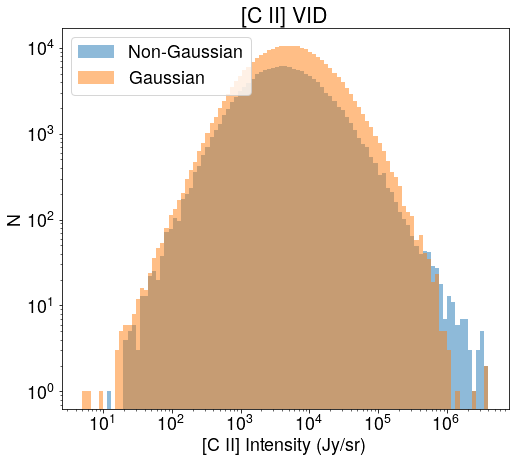

In [108]:
n_ng, _, _ = plt.hist(NonG_cubes_cut[0].value.flatten(), bins=binning, alpha=.5, label='Non-Gaussian')
n_g, _, _ = plt.hist(gaussian_cubes[0].value.flatten(), bins=binning, alpha=.5, label='Gaussian')
plt.legend()

plt.xlabel('[C II] Intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.title('[C II] VID')

plt.xscale('log')

These are the [C II] intensity distributions for one individual lightcone for both the gaussian and non-gaussian case. Now, let's take the mean of multiple lightcones:

In [109]:
n_gs = [0 for i in range(len(gaussian_cubes))]
n_ngs = [0 for i in range(len(NonG_cubes_cut))]

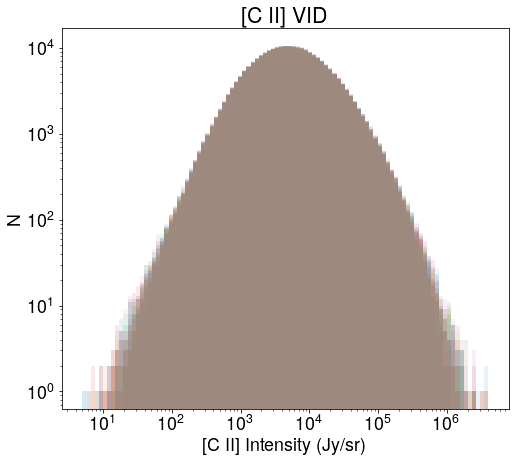

In [110]:
for i in range(len(gaussian_cubes)):
    
    n_gs[i], _, _ = plt.hist(gaussian_cubes[i].value.flatten(), bins=binning, alpha=.1)

    plt.xlabel('[C II] Intensity (Jy/sr)')
    plt.ylabel('N')
    plt.yscale('log')
    plt.title('[C II] VID')

    plt.xscale('log')

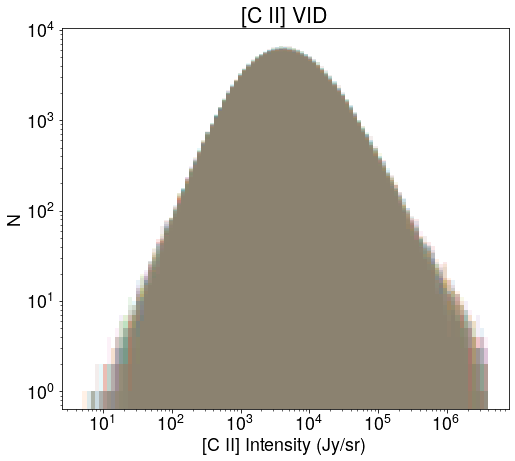

In [111]:
for i in range(len(NonG_cubes_cut)):
    
    n_ngs[i], _, _ = plt.hist(NonG_cubes_cut[i].value.flatten(), bins=binning, alpha=.1)

    plt.xlabel('[C II] Intensity (Jy/sr)')
    plt.ylabel('N')
    plt.yscale('log')
    plt.title('[C II] VID')

    plt.xscale('log')

In [112]:
avg_n_g = np.mean(n_gs, axis=0)
avg_n_ng = np.mean(n_ngs, axis=0)

Text(0, 0.5, 'N')

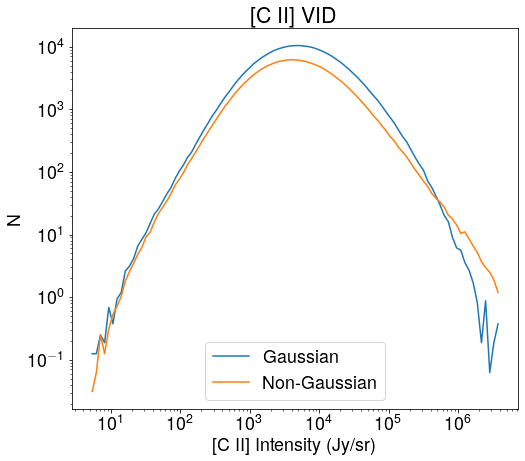

In [113]:
plt.plot(center, avg_n_g, label='Gaussian')
plt.plot(center, avg_n_ng, label='Non-Gaussian')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('[C II] VID')
plt.xlabel('[C II] Intensity (Jy/sr)')
plt.ylabel('N')

We can take the log ratio of one over the other (to get a rate as before, we would have to divide that log ratio by the step in the parameter space that was modified to generate the variant PDF (non-Gaussian) from the fiducial one (Gaussian), but I don't have it here)

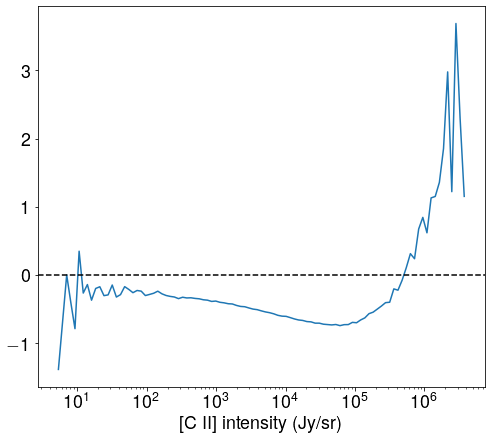

In [114]:
plt.plot(center, np.log(avg_n_ng/avg_n_g))

plt.xscale('log')
plt.xlabel('[C II] intensity (Jy/sr)')
plt.axhline(y=0, linestyle='--', color='k')

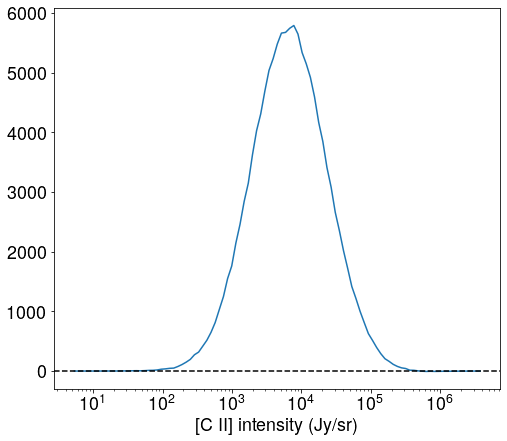

In [115]:
plt.plot(center, -avg_n_g*np.log(avg_n_ng/avg_n_g))

plt.xscale('log')
plt.xlabel('[C II] intensity (Jy/sr)')
plt.axhline(y=0, linestyle='--', color='k')